In [ ]:
!pip -q install basemap
!pip -q install basemap-data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.2/859.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 13.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [ ]:
RHO_AGE_RANGE = { # Rate at which people die (1/6 = 6 days to kill a person)
  "0-14": 0.002,
  "15-65": 0.021,
  "65+": 0.264
}
short_state_names = {
        'Alaska': 'AK',
        'Alabama': 'AL',
        'Arkansas': 'AR',
        'Arizona': 'AZ',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Iowa': 'IA',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Massachusetts': 'MA',
        'Maryland': 'MD',
        'Maine': 'ME',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Missouri': 'MO',
        'Mississippi': 'MS',
        'Montana': 'MT',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Nebraska': 'NE',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'Nevada': 'NV',
        'New York': 'NY',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Virginia': 'VA',
        'Vermont': 'VT',
        'Washington': 'WA',
        'Wisconsin': 'WI',
        'West Virginia': 'WV',
        'Wyoming': 'WY'
}

In [ ]:
pop_information = pd.read_csv("drive/MyDrive/Colab Notebooks/CPT591final/pop_age_prop_ver2.csv")
state_names = pop_information['State'].tolist()
population_each_state = pop_information['population'].tolist()
US_population = np.sum(np.array(population_each_state))
exposed_rate_each_state = pop_information['Expose_rate'].tolist()
pop_proportion_age_range = pop_information.iloc[:, 2:5].to_numpy()
rho_average = np.sum(pop_proportion_age_range * np.array(list(RHO_AGE_RANGE.values())), axis=1)
confirmed_df = pd.read_csv('drive/MyDrive/Colab Notebooks/CPT591final/confirmed_case.csv').iloc[:, 1:].to_numpy()
recovered_df = pd.read_csv('drive/MyDrive/Colab Notebooks/CPT591final/recovered_case.csv').iloc[:, 1:].to_numpy()
death_df = pd.read_csv('drive/MyDrive/Colab Notebooks/CPT591final/death_case.csv').iloc[:, 1:].to_numpy()
adjacency_matrix = np.load('drive/MyDrive/Colab Notebooks/CPT591final/flight_inf_adjacency_matrix.npy')
adjacency_matrix_no_DC = np.delete(adjacency_matrix, 7, 0)
adjacency_matrix_no_DC = np.delete(adjacency_matrix_no_DC, 7, 1)
transmission_pro_matrix = (adjacency_matrix_no_DC*100)/np.sum(adjacency_matrix_no_DC, axis=1)[:,np.newaxis] #reduce the number of transmission
transmission_pro_matrix = transmission_pro_matrix *(100/np.sum(transmission_pro_matrix, axis=1)[:,np.newaxis])
transmission_pro_matrix = transmission_pro_matrix/100
transmission_pro_matrix = transmission_pro_matrix*(np.sum(adjacency_matrix_no_DC, axis=1, keepdims=True)/365)

In [ ]:
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# Mercator projection, for Alaska and Hawaii
m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
                projection='merc',lat_ts=20) 
shp_info = m.readshapefile('drive/MyDrive/Colab Notebooks/CPT591final/st99_d00','states',drawbounds=False,
                              linewidth=0.45,color='black')
shp_info_ = m_.readshapefile('drive/MyDrive/Colab Notebooks/CPT591final/st99_d00','states',drawbounds=False)
centroid = pd.read_csv("drive/MyDrive/Colab Notebooks/CPT591final/states.csv",
                    usecols=['state', 'latitude', 'longitude'])

In [ ]:
def make_data_visualization_US_Map(m, m_, centroid, color_information, bounds=[0,0.001, 1, 3.5, 6, 8.5, 11]):
    fig, ax = plt.subplots(figsize=(15,15))
    AK_SCALE = 0.19  # scale down Alaska to show as a map inset
    HI_OFFSET_X = -1900000  # X coordinate offset amount to move Hawaii "beneath" Texas
    HI_OFFSET_Y = 250000    # similar to above: Y offset for Hawaii
    AK_OFFSET_X = -250000   # X offset for Alaska (These four values are obtained
    AK_OFFSET_Y = -750000   # via manual trial and error, thus changing them is not recommended.)
    # Lambert Conformal map of lower 48 states.
    '''m = Basemap(llcrnrlon=-119,llcrnrlat=20,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

    # Mercator projection, for Alaska and Hawaii
    m_ = Basemap(llcrnrlon=-190,llcrnrlat=20,urcrnrlon=-143,urcrnrlat=46,
                projection='merc',lat_ts=20) 

    #---------   draw state boundaries  ----------------------------------------
    shp_info = m.readshapefile('drive/MyDrive/Colab Notebooks/CPT591final/st99_d00','states',drawbounds=True,
                              linewidth=0.45,color='black')
    shp_info_ = m_.readshapefile('drive/MyDrive/Colab Notebooks/CPT591final/st99_d00','states',drawbounds=False)
    title = ['state', 'latitude', 'longitude']
    centroid = pd.read_csv("drive/MyDrive/Colab Notebooks/CPT591final/states.csv",
                    usecols=title)'''
    US49 = centroid.query('state!="Alaska" & state!="Hawaii" & state!="District of Columbia"')
    US49abbr = list()
    for full_name in US49['state'].tolist():
      US49abbr.append(short_state_names[full_name])
    AK_HI = centroid.query('state=="Alaska" | state=="Hawaii"')
    AK_HIabbr = list()
    for full_name in AK_HI['state'].tolist():
      AK_HIabbr.append(short_state_names[full_name])
    US49 = US49.set_index('state').T.to_dict('list')
    AK_HI = AK_HI.set_index('state').T.to_dict('list')
    c = np.array(list(US49.values())).transpose()
    US49_lats = c[0]
    US49_lons = c[1]
    c = np.array(list(AK_HI.values())).transpose()
    AK_HI_lats = c[0]
    AK_HI_lons = c[1]
    US49_lons, US49_lats = m(US49_lons, US49_lats)
    AK_HI_lons, AK_HI_lats = m(AK_HI_lons, AK_HI_lats)
    AK_HI_lons[0] = AK_SCALE*AK_HI_lons[0]+800000
    AK_HI_lats[0] = AK_SCALE*AK_HI_lats[0]-900000
    AK_HI_lons[1] = AK_HI_lons[1]+5200000  
    AK_HI_lats[1] = AK_HI_lats[1]-1400000
    #-------- choose a color for each state based on population density. -------
    statenames=[]
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        statenames.append(statename)

    #---------  cycle through state names, color each one.  --------------------
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['Puerto Rico', 'District of Columbia']:
            poly = Polygon(seg, facecolor=color_information[statenames[nshape]],
                           edgecolor='black', linewidth=0.5)
            ax.add_patch(poly)

    AREA_1 = 0.005  # exclude small Hawaiian islands that are smaller than AREA_1
    AREA_2 = AREA_1 * 30.0  # exclude Alaskan islands that are smaller than AREA_2

    for nshape, shapedict in enumerate(m_.states_info):  # plot Alaska and Hawaii as map insets
        if shapedict['NAME'] in ['Alaska', 'Hawaii']:
            seg = m_.states[int(shapedict['SHAPENUM'] - 1)]
            if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > AREA_1:
                seg = [(x + HI_OFFSET_X, y + HI_OFFSET_Y) for x, y in seg]
            elif shapedict['NAME'] == 'Alaska' and float(shapedict['AREA']) > AREA_2:
                seg = [(x*AK_SCALE + AK_OFFSET_X, y*AK_SCALE + AK_OFFSET_Y)\
                      for x, y in seg]
            poly = Polygon(seg, facecolor=color_information[shapedict['NAME']], 
                          edgecolor='black', linewidth=0.5)
            ax.add_patch(poly)

    for i in range(len(US49_lons)):
      plt.text(US49_lons[i], US49_lats[i], US49abbr[i], ha="center")
    for i in range(len(AK_HI_lons)):
      plt.text(AK_HI_lons[i], AK_HI_lats[i], AK_HIabbr[i], ha="center")

    #---------  Plot bounding boxes for Alaska and Hawaii insets  --------------
    light_gray = [0.8]*3  # define light gray color RGB
    x1,y1 = m_([-190,-183,-180,-180,-175,-171,-171],[29,29,26,26,26,22,20])
    x2,y2 = m_([-180,-180,-177],[26,23,20])  # these numbers are fine-tuned manually
    m_.plot(x1,y1,color=light_gray,linewidth=0.8)  # do not change them drastically
    m_.plot(x2,y2,color=light_gray,linewidth=0.8)

    #------------   Show color bar  ---------------------------------------
    ax_c = fig.add_axes([0.9, 0.235, 0.03, 0.52])
    cmap = mpl.colors.ListedColormap(['white', 'cyan', 'blue', 'yellow', 'orange', 'red'])
    bounds = bounds
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                      label='Infected Population * 10000')

    plt.show()

In [ ]:
full_state_name_list = list(short_state_names.keys())
def values2color(assigned_day_values, full_state_name_list=full_state_name_list):
    color_information = dict()
    for i in range(len(assigned_day_values)):
        if assigned_day_values[i] <= 0.001:
            color_information[full_state_name_list[i]] = 'white'
        elif assigned_day_values[i] > 0.001 and assigned_day_values[i] < 10000:
            color_information[full_state_name_list[i]] = 'cyan'
        elif assigned_day_values[i] > 10000 and assigned_day_values[i] < 35000:
            color_information[full_state_name_list[i]] = 'blue'
        elif assigned_day_values[i] > 35000 and assigned_day_values[i] < 60000:
            color_information[full_state_name_list[i]] = 'yellow'
        elif assigned_day_values[i] > 60000 and assigned_day_values[i] < 85000:
            color_information[full_state_name_list[i]] = 'orange'
        else:
            color_information[full_state_name_list[i]] = 'red'
    return color_information

In [ ]:
def data_split(data, orders=3, start=10):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]

    return x_train, y_train

def data_preprocessing(population, confirmed, recovered, death):
    I = confirmed - recovered - death
    R = recovered + death
    D = death

    N = np.array([population] * len(I), dtype=np.float64)
    S = N - I - R

    gamma = (R[1:] - R[:-1]) / I[:-1]
    beta = N[:-1] * (I[1:] - I[:-1] + R[1:] - R[:-1]) / (I[:-1] * (N[:-1] - I[:-1] - R[:-1]))
    r0 = beta / gamma
    return S, I, R, D, beta, r0

def Ridge_model(x_data, y_data, regularization):
    clf = Ridge(alpha=regularization, copy_X=True, fit_intercept=False, max_iter=None, 
                random_state=None, solver='auto', tol=1e-08).fit(x_data, y_data)
    return clf

def show_clf_prediction_result(clf_predict_set):
    y_beta, beta_hat, y_r0, r0_hat = clf_predict_set
    ##### Plot the training and testing results #####
    plt.figure(1)
    plt.plot(y_beta, label=r'$\beta (t)$')
    plt.plot(beta_hat, label=r'$\hat{\beta}(t)$')
    plt.legend()

    plt.figure(2)
    plt.plot(y_r0, label=r'R0 (t)')
    plt.plot(r0_hat, label=r'$\hat{R0}(t)$')
    plt.legend()

In [ ]:
def initialize_parameters(S, I, R, D, start_point, beta, r0, exposed_rate):
    #print(exposed_rate)
    S_predict = S[start_point]
    E_predict = I[start_point]*exposed_rate
    I_predict = I[start_point]
    R_predict = R[start_point]
    D_predict = D[start_point]
    predict_beta_list = np.array(beta[(start_point-3):start_point]).tolist()
    predict_r0_list = np.array(r0[(start_point-3):start_point]).tolist()
    return [S_predict, E_predict, I_predict, R_predict, D_predict], predict_beta_list, predict_r0_list

def SEIRD(setting, population, beta_factor, predict_beta, predict_r0, sigma, alpha, rho):
    S_predict, E_predict, I_predict, R_predict, D_predict = setting
    predict_gamma = predict_beta/predict_r0
    next_S = ((-beta_factor * predict_beta * S_predict *
               (E_predict+I_predict)) / population) + S_predict
    next_E = ((beta_factor * predict_beta * S_predict * 
               (E_predict+I_predict)) / population) - (sigma * E_predict) + E_predict
    next_I = (sigma * E_predict) - (1 - alpha)*predict_gamma*I_predict - alpha*rho*I_predict + I_predict
    next_R = (1-alpha) * predict_gamma * I_predict + R_predict
    next_D = alpha*rho*I_predict + D_predict
    return [next_S, next_E, next_I, next_R, next_D]

In [ ]:
DISEASE_SCALING_FACTOR = 0.2 # Models out how overburdened the healthcare system becomes the more infected there are.
ALPHA = 0.07 # Probability that the disease will kill a person
SIGMA = 1/2.7 # The rate a person exposed to the disease becomes infectious (1/incubationPeriod)

def overworkedAlpha_healthcare(I, N, alpha=ALPHA, disease_factor=DISEASE_SCALING_FACTOR):
    overworkedAlpha = disease_factor * (I/N)
    return overworkedAlpha + alpha

In [ ]:
class Agent:
  def __init__(self, id, name, sd_day, sd_factor, population, 
               exposed_rate, Rho_average, confirmed, recovered, death):
      self.S, self.I, self.R, self.D, self.beta, self.r0 = data_preprocessing(population, confirmed, 
                                                                              recovered, death)
      self.id = id
      self.name = name
      self.state = 'S'
      self.sd_day = sd_day
      self.sd_factor = sd_factor
      self.population = population
      self.Rho_average = Rho_average
      self.exposed_rate = exposed_rate
      self.x_beta, self.y_beta = data_split(self.beta, start=3)
      self.x_r0, self.y_r0 = data_split(self.r0, start=3)
      self.clf_beta = Ridge_model(self.x_beta, self.y_beta, 0.003765)
      self.clf_r0 = Ridge_model(self.x_r0, self.y_r0, 0.000685)
      self.epidemic_info_list = list()
      setting, self.predict_beta_list, self.predict_r0_list = \
          initialize_parameters(self.S, self.I, self.R, self.D, 3, self.beta, self.r0, self.exposed_rate)
      self.epidemic_info_list.append(setting)
      self.current_day = 0
      self.turning_point = 0
      self.BETA_FACTOR = 1.0

  def clf_predict(self):
      beta_hat = self.clf_beta.predict(self.x_beta)
      r0_hat = self.clf_r0.predict(self.x_r0)
      return [self.y_beta, beta_hat, self.y_r0, r0_hat]

  def update_current_day(self):
      self.current_day += 1

  def updata_infected_state(self):
      self.state = 'I'

  def update_no_disease(self):
      next_setting = [self.population, 0, 0, 0, 0]
      self.epidemic_info_list.insert(0, next_setting)
      return next_setting[2]/self.population

  def reset(self):
      self.epidemic_info_list = list()
      setting, self.predict_beta_list, self.predict_r0_list = \
          initialize_parameters(self.S, self.I, self.R, self.D, 3, self.beta, self.r0, self.exposed_rate)
      self.epidemic_info_list.append(setting)
      self.state = 'S'
      self.current_day = 0
      self.turning_point = 0

  def update_exposed_people(self, exposed_people):
      self.epidemic_info_list[-1][1] = self.epidemic_info_list[-1][1] + exposed_people
      self.population += exposed_people
      if self.epidemic_info_list[-1][1] < 0:
        self.epidemic_info_list[-1][1] = 0
      if self.population < 0:
        self.population = 0

  def update_SERID(self):
      beta_factor = self.BETA_FACTOR
      predict_gamma = self.predict_beta_list[-1]/self.predict_r0_list[-1]
      if self.predict_beta_list[-1] > predict_gamma:
        self.turning_point += 1
      next_beta = self.clf_beta.predict(np.asarray([self.predict_beta_list[-3:]]))[0]
      next_r0 = self.clf_r0.predict(np.asarray([self.predict_r0_list[-3:]]))[0]
      if next_beta < 0:
        next_beta = 0
      if next_r0 < 0:
        next_r0 = 0
      self.predict_beta_list.append(next_beta)
      self.predict_r0_list.append(next_r0)
      if self.current_day > self.sd_day:
        beta_factor -= self.sd_factor
      workedALPHA = overworkedAlpha_healthcare(self.epidemic_info_list[-1][2], self.population)
      next_setting = SEIRD(self.epidemic_info_list[-1], self.population, beta_factor, self.predict_beta_list[-1], 
                          self.predict_r0_list[-1], SIGMA, workedALPHA, self.Rho_average)
      if next_setting[1] < 0.0:
        next_setting[1] = 0.0
      if next_setting[2] < 0.0:
        next_setting[2] = 0.0
      self.epidemic_info_list.append(next_setting)
      return next_setting[1]/self.population

In [ ]:
def collect_exposed_population(index, exposed_percentage_array, transmission_prob_matrix):
    outgoing = np.sum(exposed_percentage_array[index] * transmission_prob_matrix[index])
    incoming = np.sum(exposed_percentage_array * transmission_prob_matrix[:, index])
    return incoming - outgoing

In [ ]:
def make_all_states_information_plot(agent_name, all_information, total_day, 
                                     SD_day, S=False, E=False, I=False, R=False, D=False):
    ########## Plot the time evolution of the time-dependent SIR model ##########
    plt.figure(figsize=(20, 10))
    if S:
        type_name = 'Shows the number of susceptible People' 
        S_information = all_information[:,0,:]
        length = np.size(S_information, axis=-1)
        for i in range(len(agent_name)):
          col = (np.random.random(), np.random.random(), np.random.random())
          plt.plot(range(length), S_information[i], '*-', label=agent_name[i], color=col)
    if E:
        type_name = 'Shows the number of Exposed People' 
        E_information = all_information[:,1,:]
        length = np.size(E_information, axis=-1)
        for i in range(len(agent_name)):
          col = (np.random.random(), np.random.random(), np.random.random())
          plt.plot(range(length), E_information[i], '*-', label=agent_name[i], color=col)
    if I:
        type_name = 'Shows the number of Infected People'
        I_information = all_information[:,2,:]
        length = np.size(I_information, axis=-1)
        for i in range(len(agent_name)):
          col = (np.random.random(), np.random.random(), np.random.random())
          plt.plot(range(length), I_information[i], '*-', label=agent_name[i], color=col)
    if R:
        type_name = 'Shows the number of Recovered People'
        R_information = all_information[:,3,:]
        length = np.size(R_information, axis=-1)
        for i in range(len(agent_name)):
          col = (np.random.random(), np.random.random(), np.random.random())
          plt.plot(range(length), R_information[i], '*-', label=agent_name[i], color=col)

    if D:
        type_name = 'Shows the number of Death People'
        D_information = all_information[:,4,:]
        length = np.size(D_information, axis=-1)
        for i in range(len(agent_name)):
          col = (np.random.random(), np.random.random(), np.random.random())
          plt.plot(range(length), D_information[i], '*-', label=agent_name[i], color=col)

    if SD_day < total_day:
      plt.axvline(x=SD_day, color='black')
    plt.xlabel('Day')
    plt.ylabel('Population')
    plt.title(f'{type_name} in SEIRD model.')
    plt.legend()

In [ ]:
def check_infectected_states(state_names, check_infectection):
    uninfected_state_name = list()
    total_num_infected_states = 0
    for name in state_names:
      if check_infectection[name] != 'I':
        uninfected_state_name.append(name)
      else:
        total_num_infected_states+= 1
    print(f'uninfected state: {uninfected_state_name}')
    print(f'Total number of infected states: {total_num_infected_states}')

In [ ]:
STOP_DAY = 150
SOCIAL_DISTANCE_DAY = 100 # Day Social Distancing happened****************************
BETA_FACTOR = 1.0 # The beta factor when Social Distancing does not happend
SOCIAL_DISTANCE_FACTOR = 0.7 
EXPOSING_THRESHOLD = 25 # the threshold of exposed people to let state start being infected

In [ ]:
agent_dict = dict()
agent_name = state_names
for i in range(len(transmission_pro_matrix)):
  agent_dict[agent_name[i]] = Agent(i, agent_name[i], SOCIAL_DISTANCE_DAY, SOCIAL_DISTANCE_FACTOR, 
                                    population_each_state[i], exposed_rate_each_state[i], 
                                    rho_average[i], confirmed_df[i], recovered_df[i], death_df[i])

In [ ]:
Epidemic_starter = ['CA', 'NY'] #*****************************

In [ ]:
#when current day = 0
exposed_percentage_array = np.zeros(shape=len(agent_dict.keys()))
for index, name in enumerate(agent_dict.keys()):
  if name in Epidemic_starter:
    agent_dict[name].updata_infected_state()
    exposed_percentage = agent_dict[name].update_SERID()
    exposed_percentage_array[index] = exposed_percentage
  else:
    exposed_percentage = agent_dict[name].update_no_disease()
    exposed_percentage_array[index] = exposed_percentage
  agent_dict[name].update_current_day()

#when current day >0
tmp_exposed_percentage_array = np.zeros(shape=len(agent_dict.keys()))
while agent_dict[Epidemic_starter[0]].current_day < STOP_DAY:
  exposed_people = exposed_percentage_array @ transmission_pro_matrix
  for index, name in enumerate(agent_dict.keys()):
    if exposed_people[index] >= EXPOSING_THRESHOLD or agent_dict[name].state == 'I':
      agent_dict[name].updata_infected_state()
      agent_dict[name].update_exposed_people(
          collect_exposed_population(index, exposed_percentage_array, transmission_pro_matrix))
      exposed_percentage = agent_dict[name].update_SERID()
      tmp_exposed_percentage_array[index] = exposed_percentage
    else:
      exposed_percentage = agent_dict[name].update_no_disease()
      tmp_exposed_percentage_array[index] = exposed_percentage
    agent_dict[name].update_current_day()
    exposed_percentage_array = tmp_exposed_percentage_array

all_information = np.array([np.array(agent_dict[name].epidemic_info_list).transpose() for name in agent_dict.keys()])
check_infectection = dict()
print(all_information.shape)
for name in agent_dict.keys():
  check_infectection[name] = agent_dict[name].state
  agent_dict[name].reset()

(50, 5, 151)


In [ ]:
check_infectected_states(state_names, check_infectection)

uninfected state: ['DE', 'NH', 'VT', 'WV', 'WY']
Total number of infected states: 45


In [ ]:
#Focus on CA, NY, FL, TX, IL, NJ top 6 serious infected state

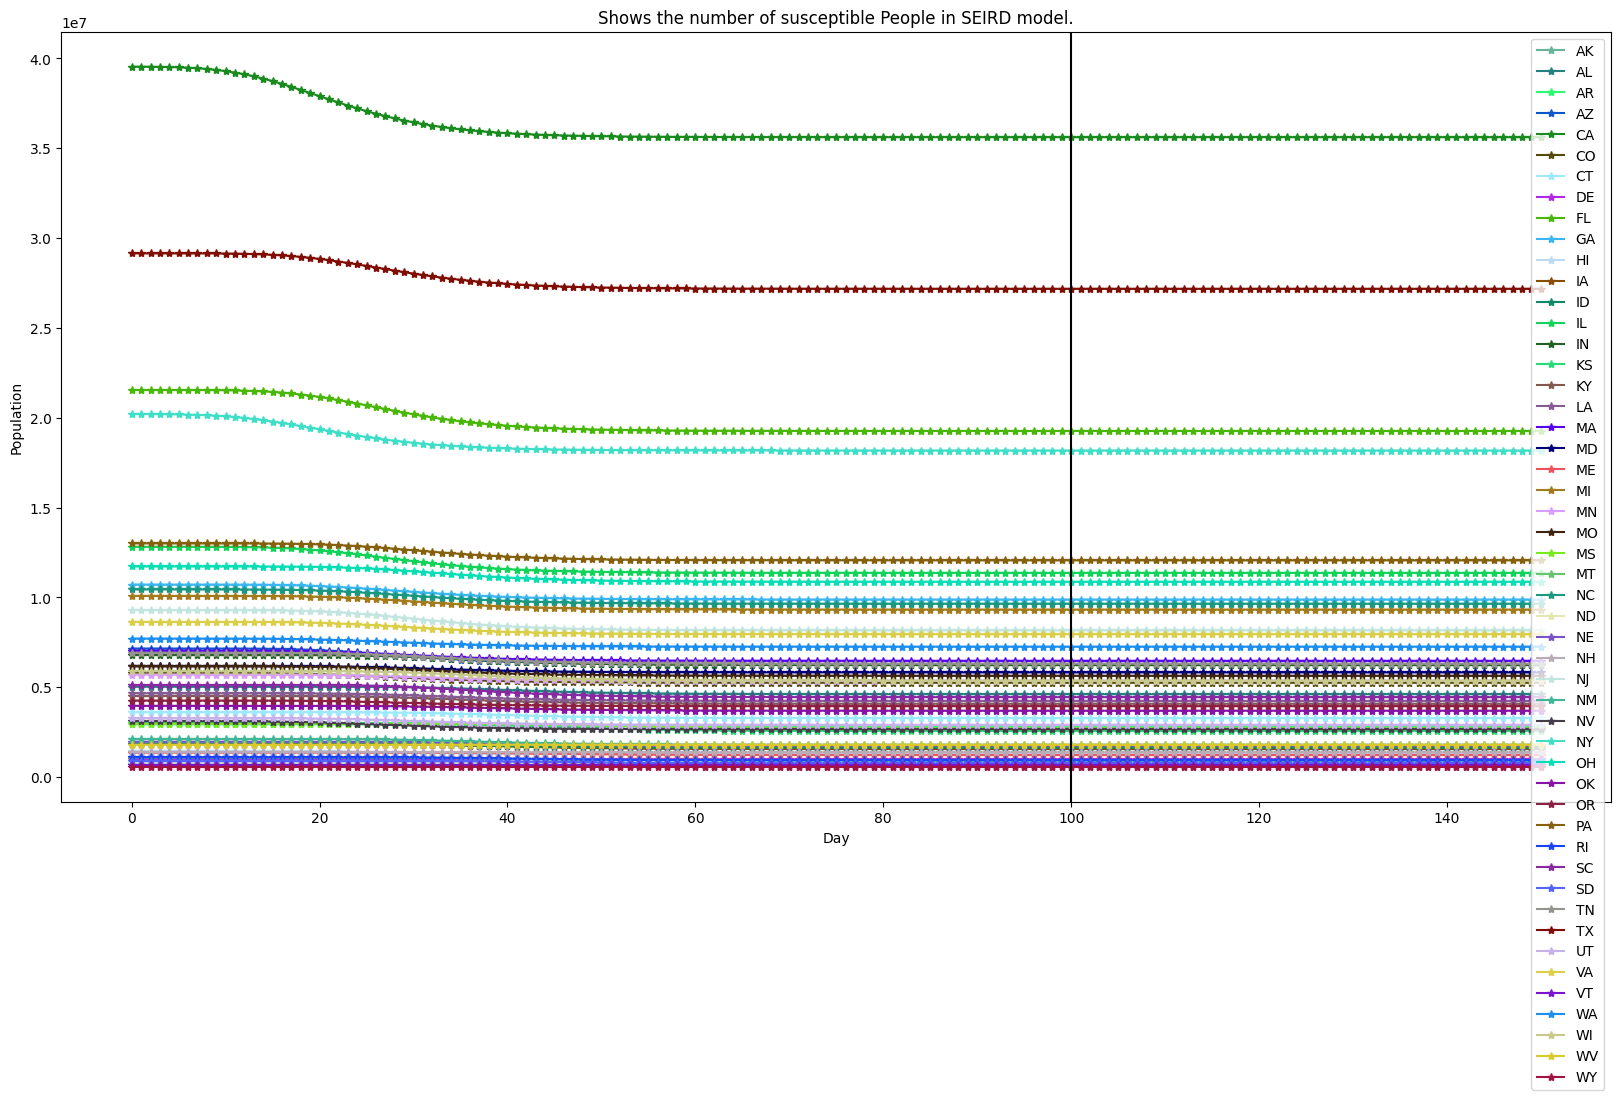

In [ ]:
make_all_states_information_plot(agent_name, all_information, STOP_DAY, SOCIAL_DISTANCE_DAY, S=True)

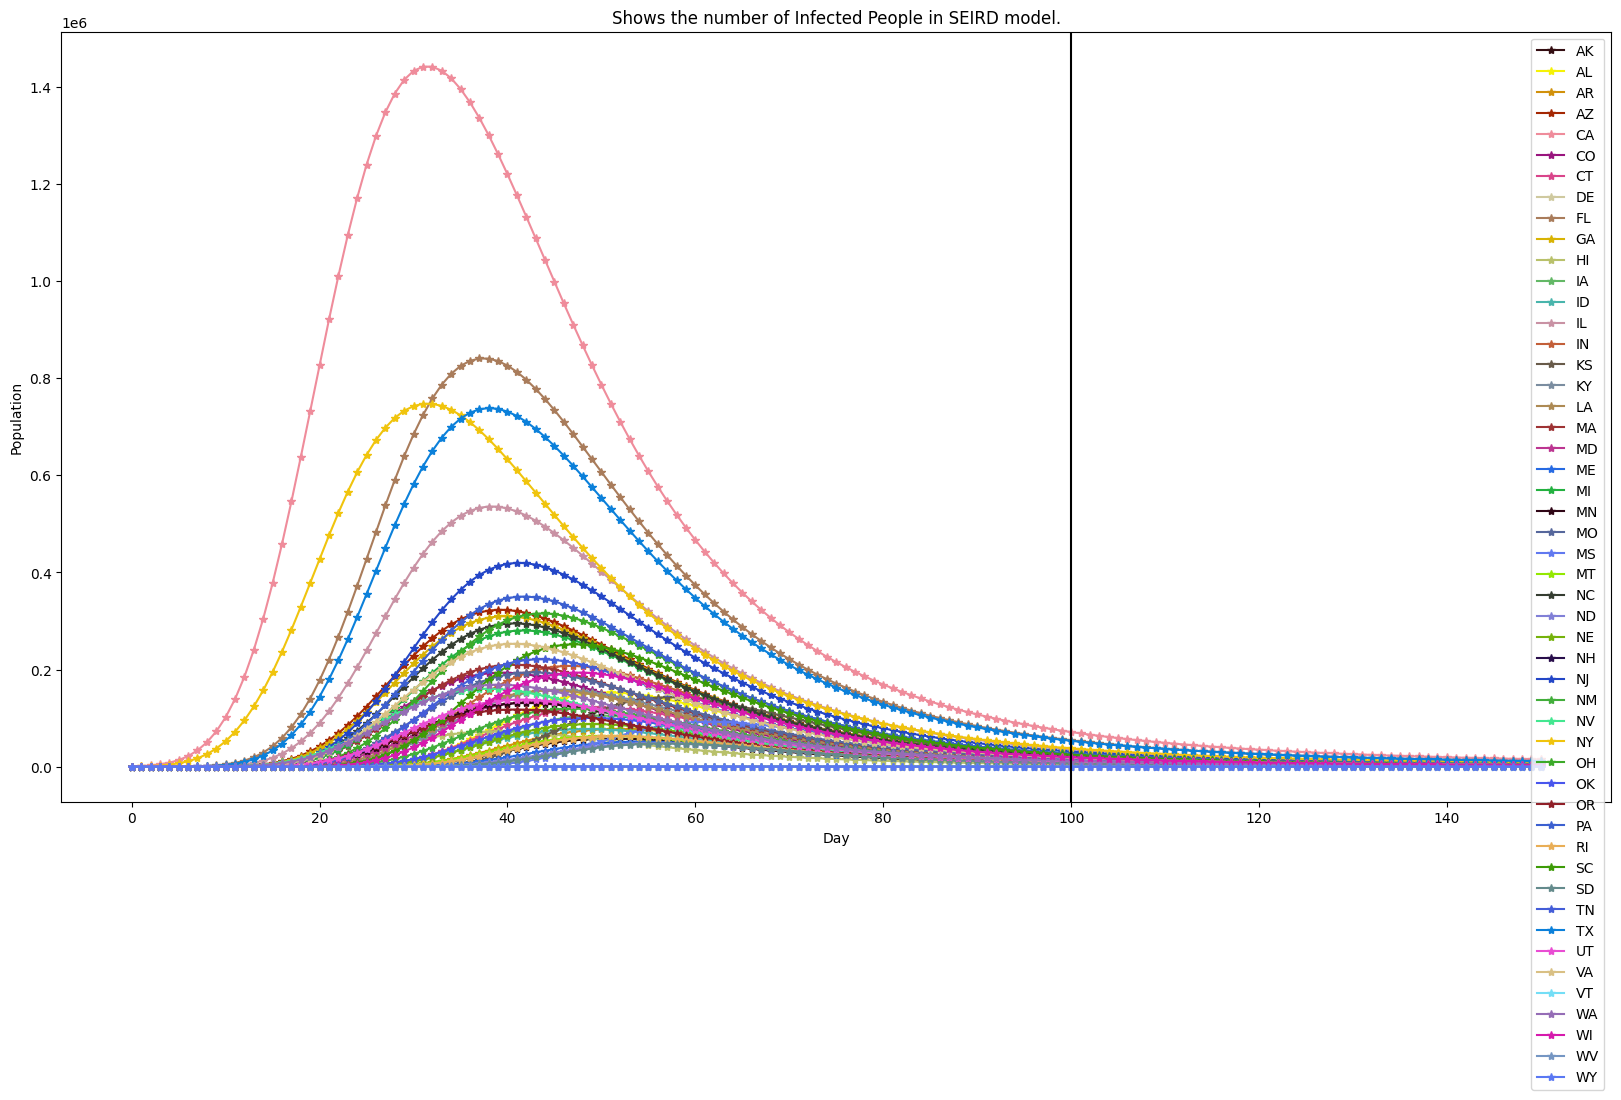

In [ ]:
make_all_states_information_plot(agent_name, all_information, STOP_DAY, SOCIAL_DISTANCE_DAY, I=True)

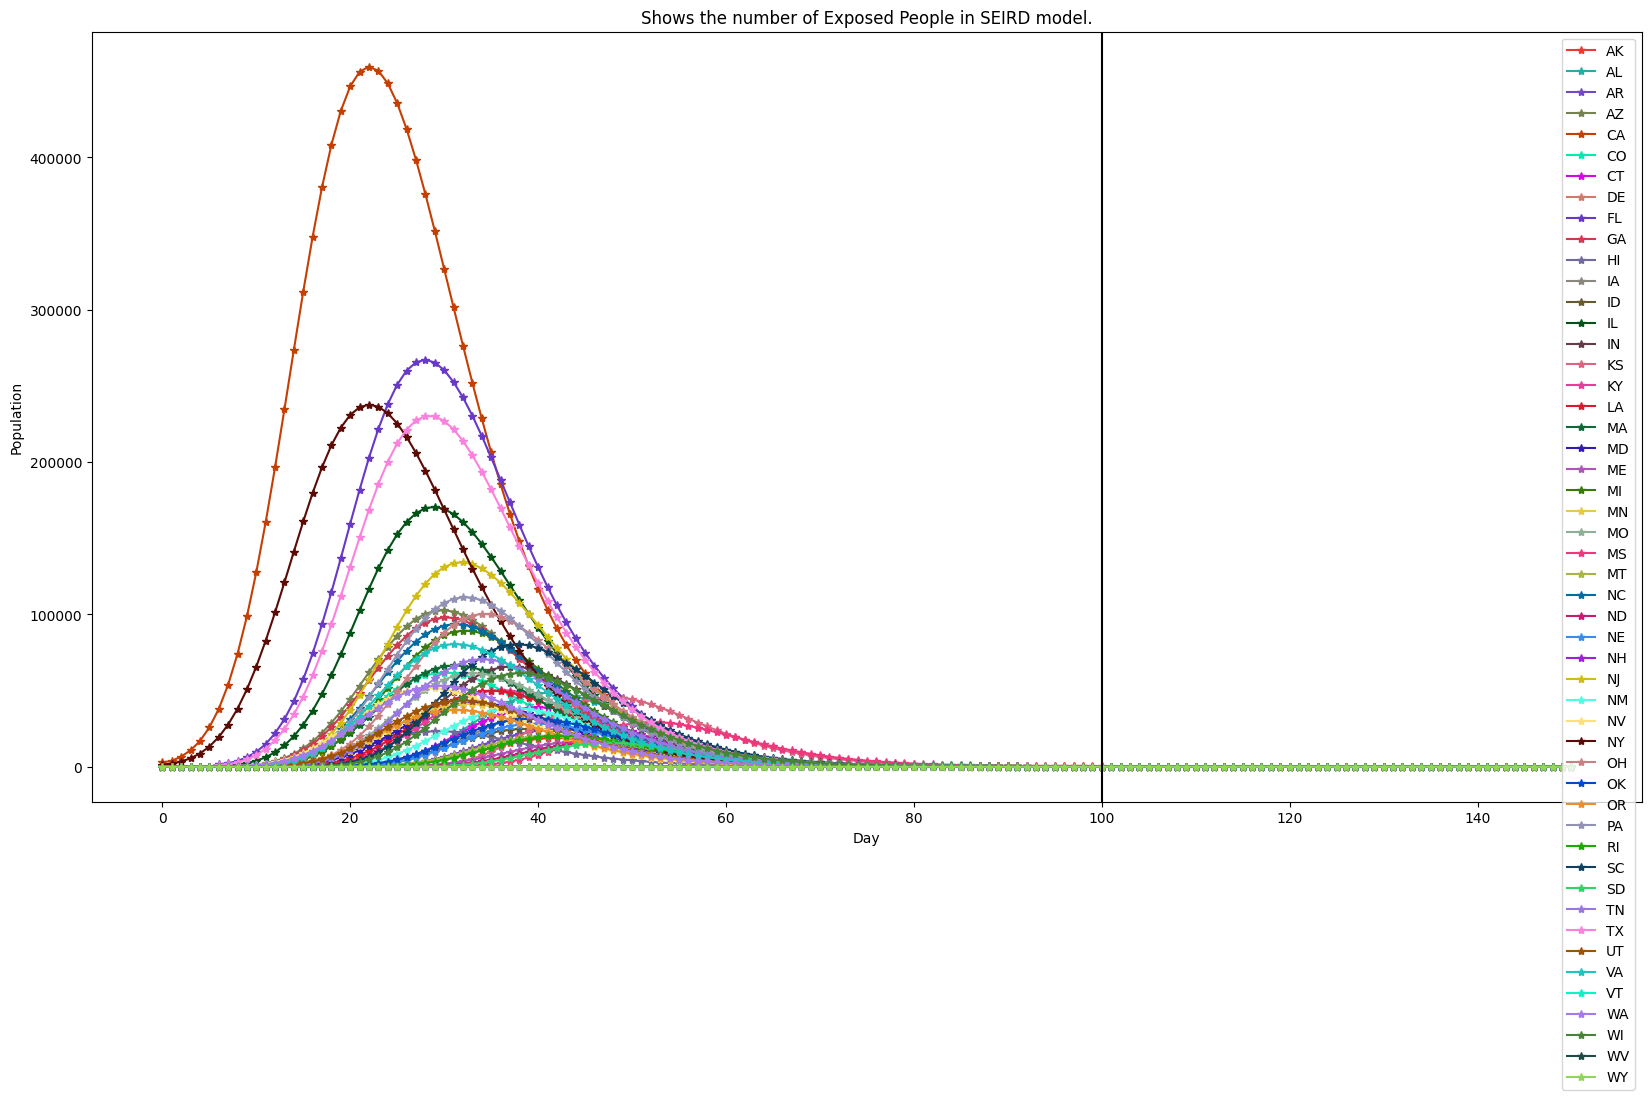

In [ ]:
make_all_states_information_plot(agent_name, all_information, STOP_DAY, SOCIAL_DISTANCE_DAY, E=True)

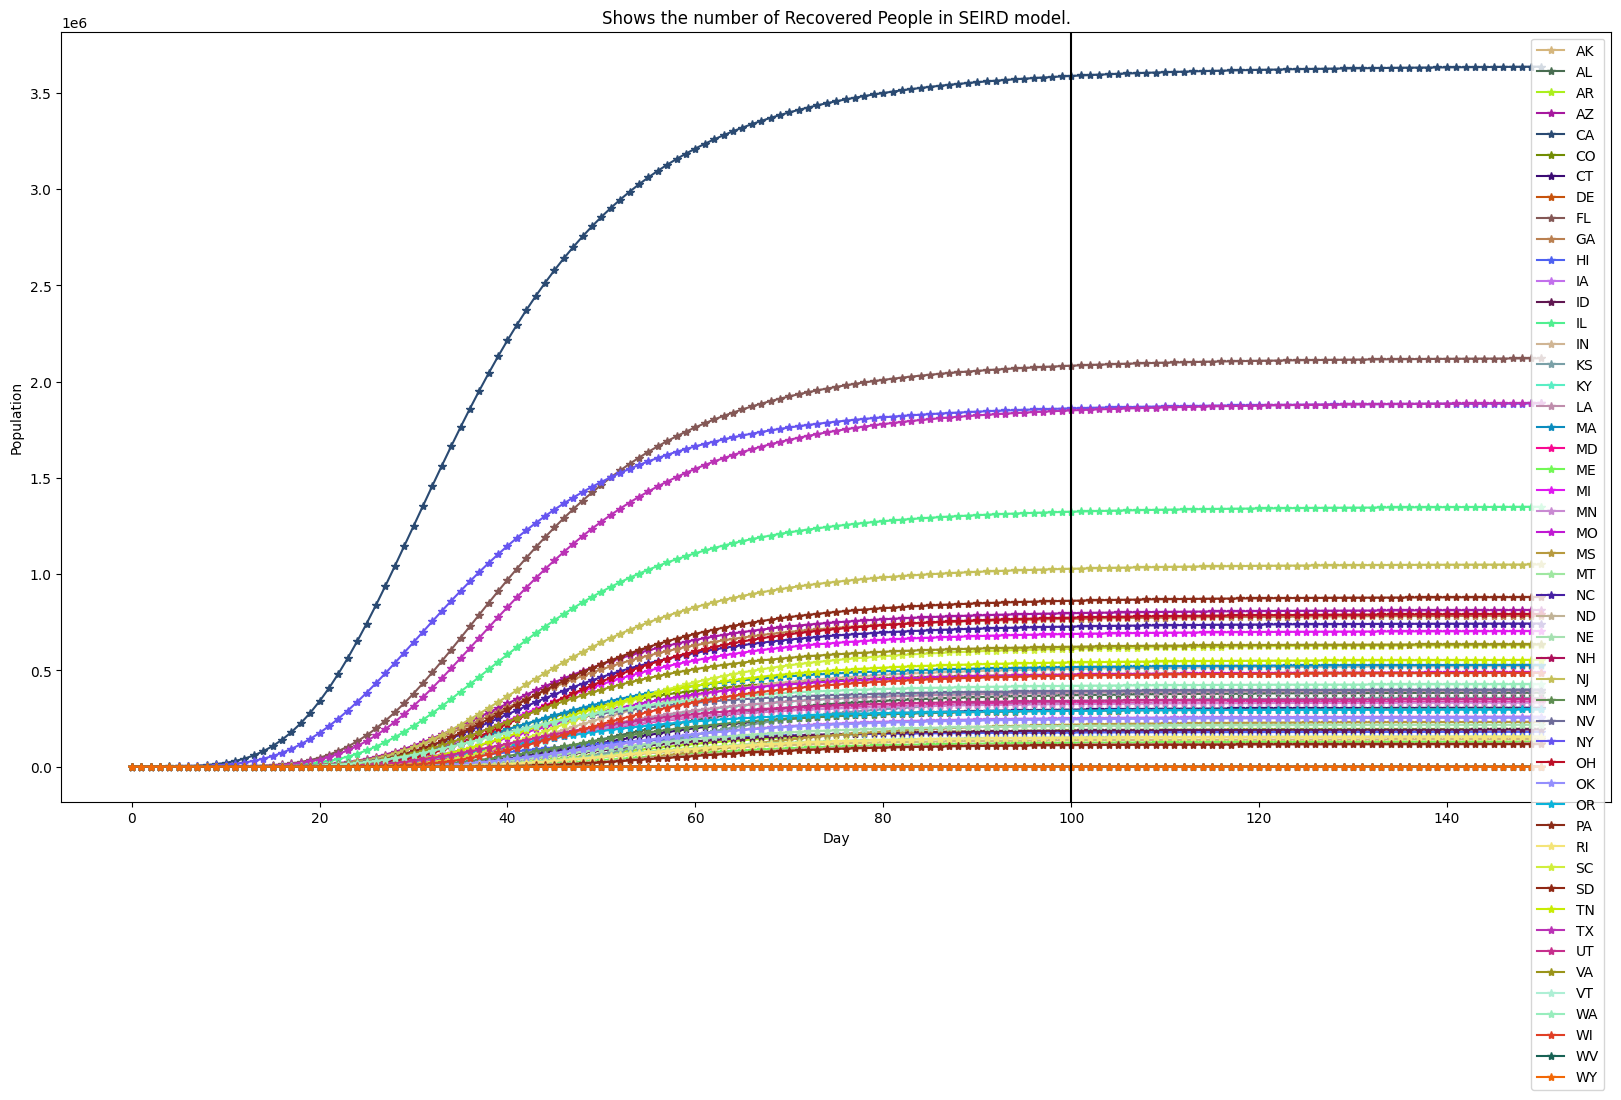

In [ ]:
make_all_states_information_plot(agent_name, all_information, STOP_DAY, SOCIAL_DISTANCE_DAY, R=True)

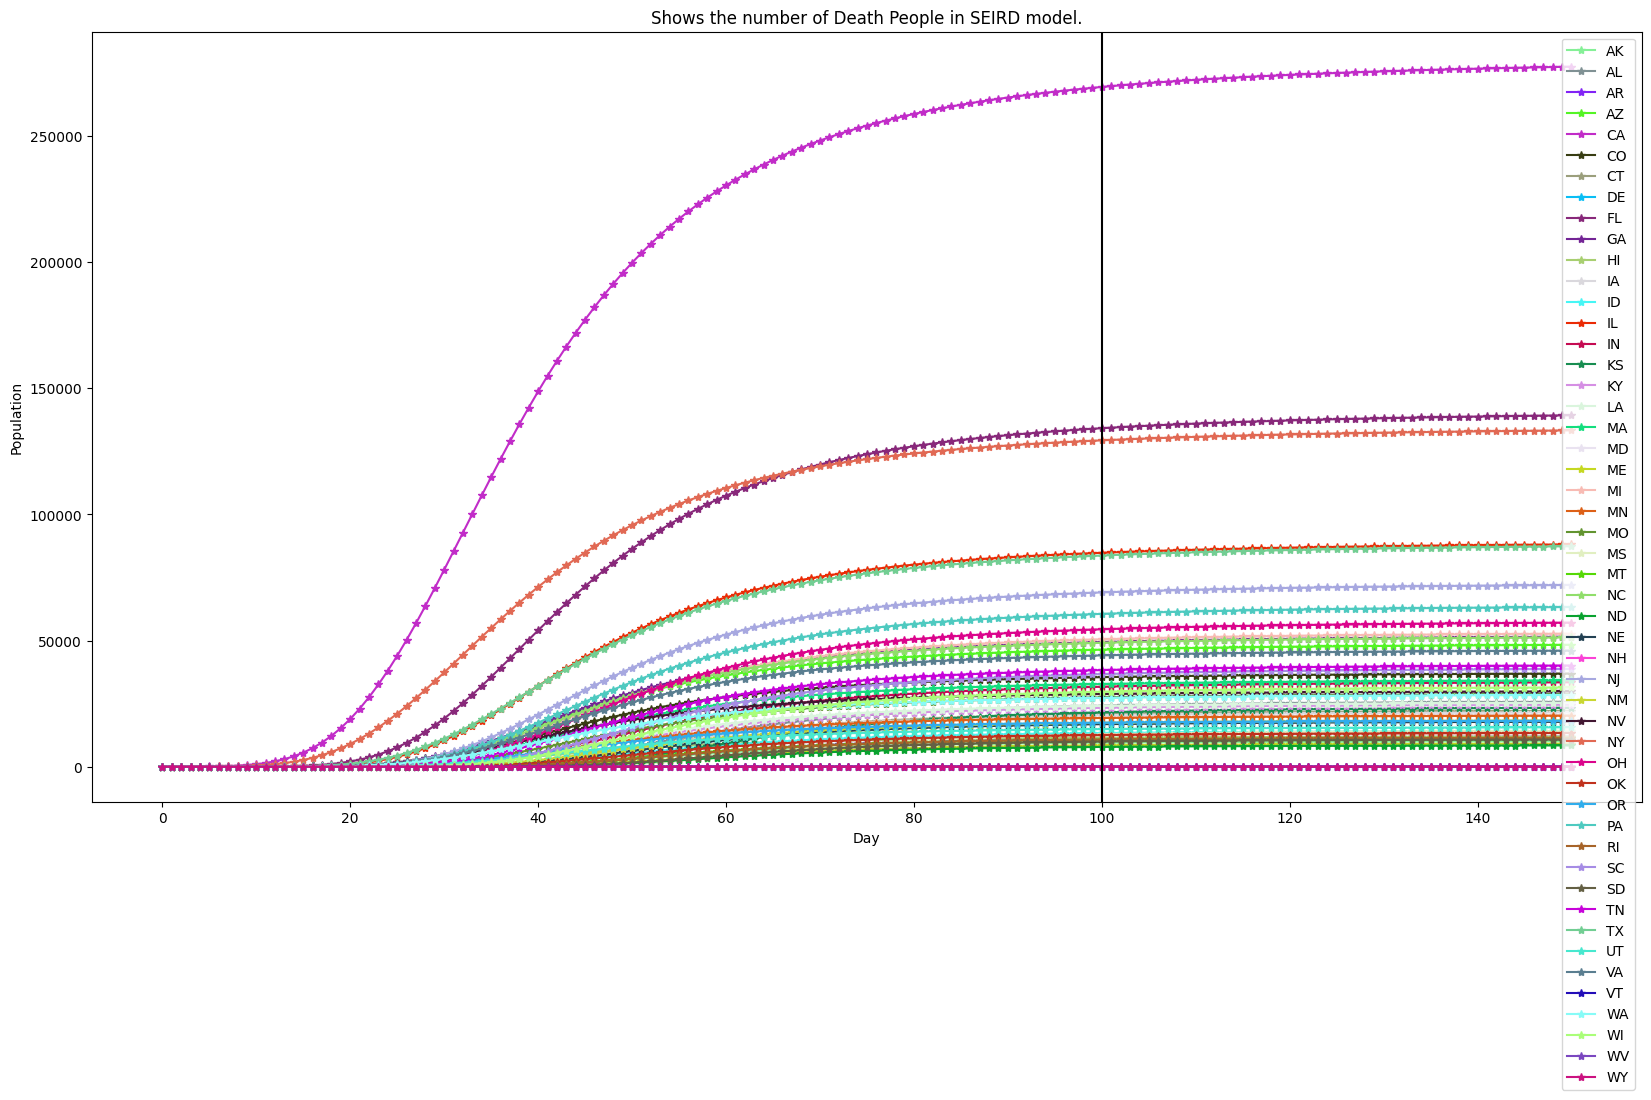

In [ ]:
make_all_states_information_plot(agent_name, all_information, STOP_DAY, SOCIAL_DISTANCE_DAY, D=True)

In [ ]:
def make_SEIRD_US_plot(information, total_day, SD_day, population=US_population, percent=True, S=True, E=True, I=True, R=True, D=True):
    #information = np.array(information).transpose()
    S_predict, E_predict, I_predict, R_predict, D_predict = information

    ########## Print Info ##########
    #print('\nConfirmed cases tomorrow:', np.rint(I_predict[-1] + R_predict[-1] + D_predict[-1]))
    #print('Infected persons tomorrow:', np.rint(I_predict[-1]))
    #print('Recovered + Death persons tomorrow:', np.rint(R_predict[-1]+ D_predict[-1]))
    print(f'The day has the highest infected people: {np.argmax(I_predict)}')
    print('\nEnd day:', total_day)
    print('Confirmed cases on the end day:', np.rint(I_predict[-1] + R_predict[-1] + D_predict[-1]))

    if percent:
        factor = population*0.01
    else:
        factor = 1.0
    ########## Plot the time evolution of the time-dependent SIR model ##########
    plt.figure(figsize=(20, 10))
    if S:
        plt.plot(range(len(I_predict)), S_predict/factor, '*-', label=r'$\hat{S}(t)$', color='green')
    if E:
        plt.plot(range(len(I_predict)), E_predict/factor, '*-', label=r'$\hat{E}(t)$', color='grey')
    if I:
        plt.plot(range(len(I_predict)), I_predict/factor, '*-', label=r'$\hat{I}(t)$', color='darkorange')
    if R:
        plt.plot(range(len(I_predict)), R_predict/factor, '*-', label=r'$\hat{R}(t)$', color='blue')
    if D:
        plt.plot(range(len(I_predict)), D_predict/factor, '*-', label=r'$\hat{D}(t)$', color='red')

    highest_peak = np.argmax(I_predict)
    highest_infection = I_predict[highest_peak]
    plt.axvline(x=highest_peak, linestyle='--', color='grey')
    plt.axhline(y=highest_infection, linestyle='--', color='darkorange')
    print(f'The number of the highest infected people: {round(highest_infection)}')
    #plt.plot(range(len(X)), X, 'o--', label=r'$X(t)$', color='chocolate')
    #plt.plot(range(len(X)), R, 'o--', label=r'$R(t)$', color='darkgreen')
    #if SD_day < total_day:
      #plt.axvline(x=SD_day, color='black')
    plt.xlabel('Day')
    if percent:
        plt.ylabel('Population percentage')
    else:
        plt.ylabel('Population')
    plt.title('SEIRD tracking line of the whole US.')
    plt.legend()

The day has the highest infected people: 41

End day: 150
Confirmed cases on the end day: 29627852.0
The number of the highest infected people: 9827706


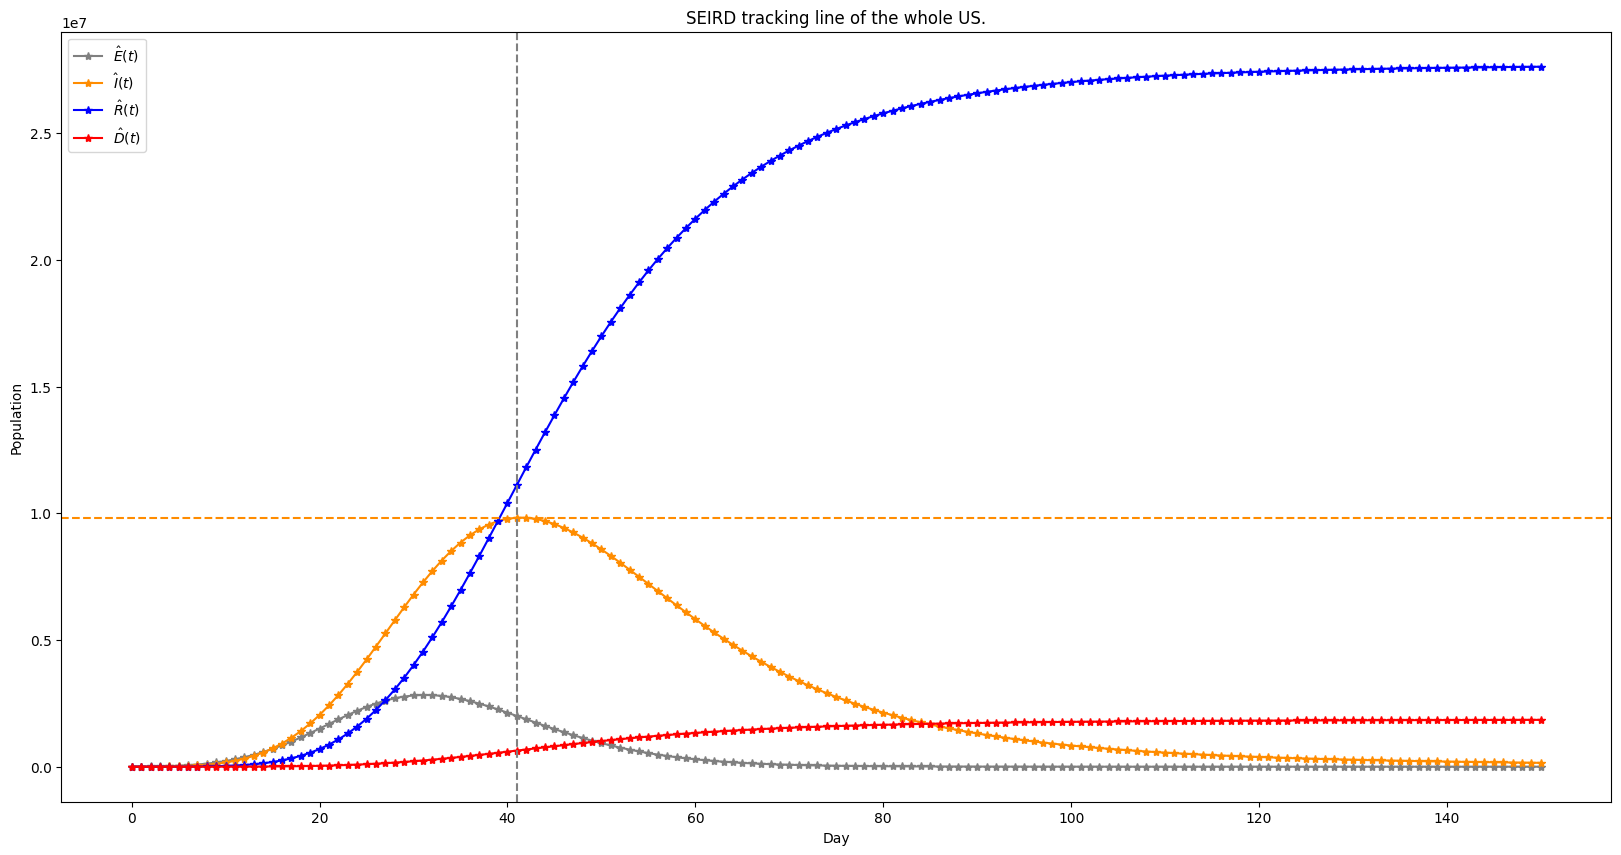

In [ ]:
make_SEIRD_US_plot(np.sum(all_information, axis=0), STOP_DAY, 
                   SOCIAL_DISTANCE_DAY, percent=False, S=False)

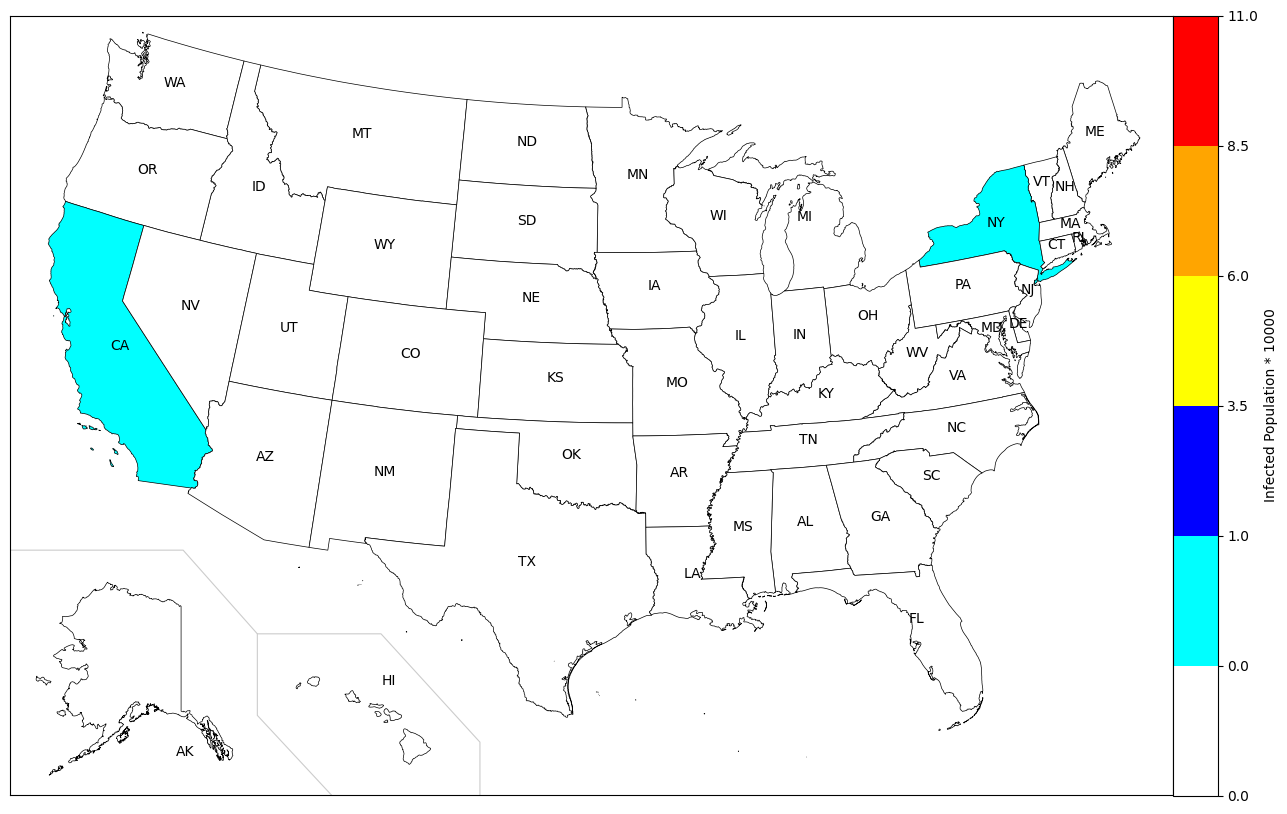

In [ ]:
make_data_visualization_US_Map(m, m_, centroid, values2color(all_information[:,2, 0]))

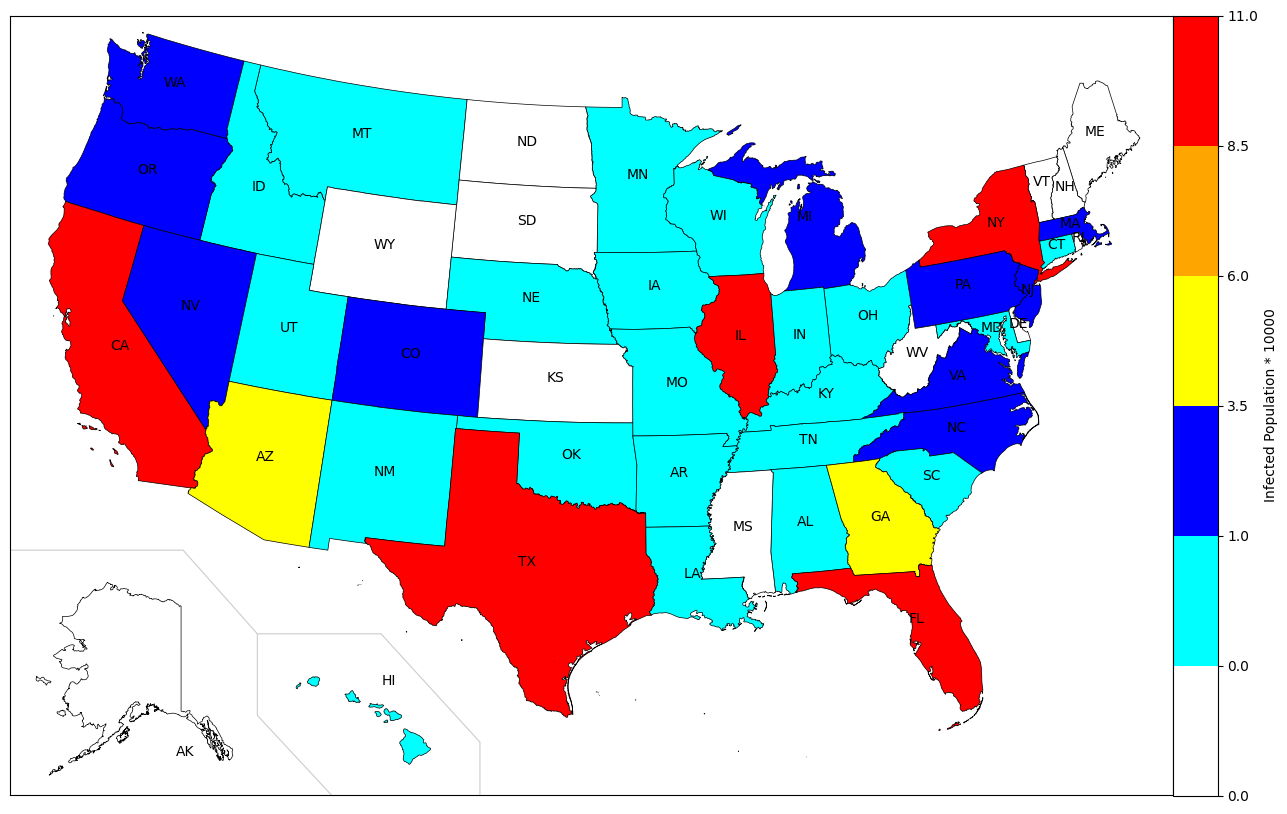

In [ ]:
make_data_visualization_US_Map(m, m_, centroid, values2color(all_information[:,2, 20]))

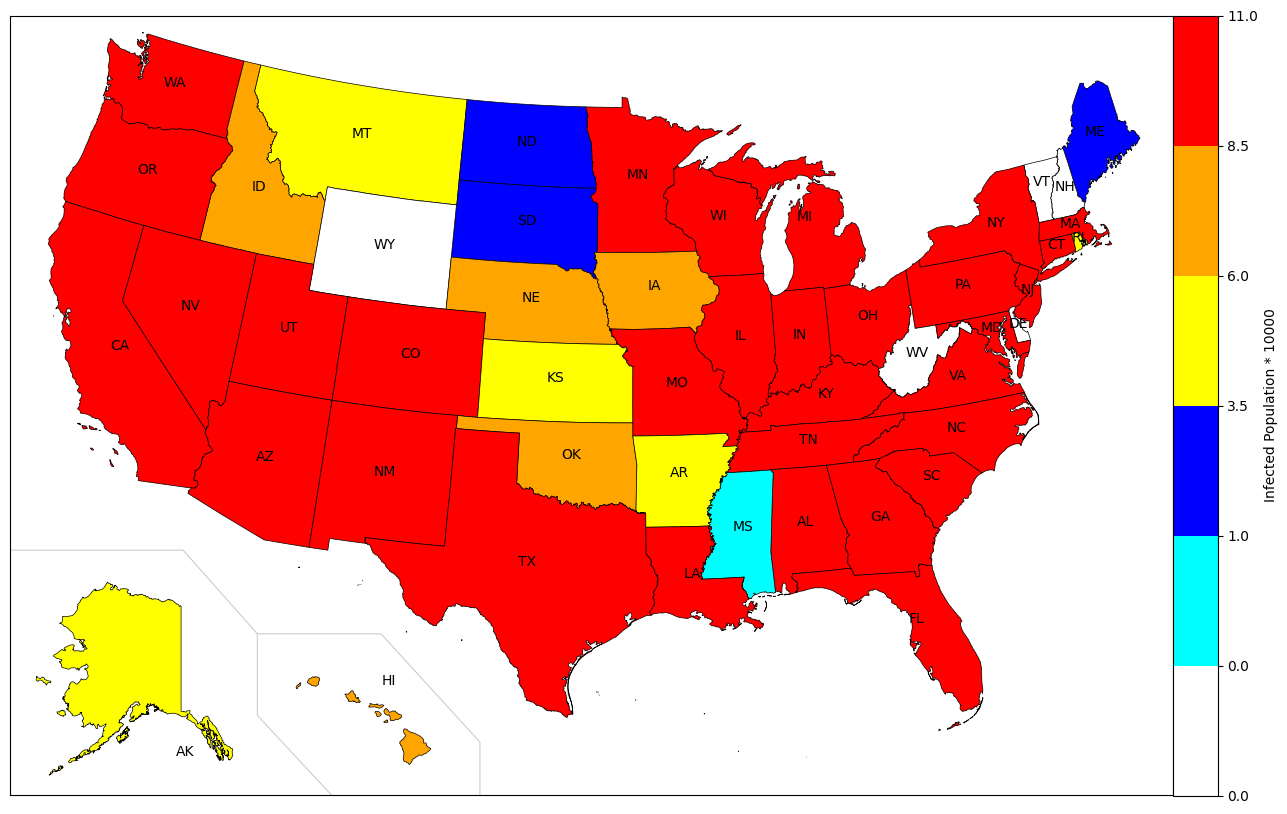

In [ ]:
# Don't put 150th day the actuall end day is 149th day [0, 149]-->[1, 150]
make_data_visualization_US_Map(m, m_, centroid, values2color(all_information[:,2, 41]))#41th day

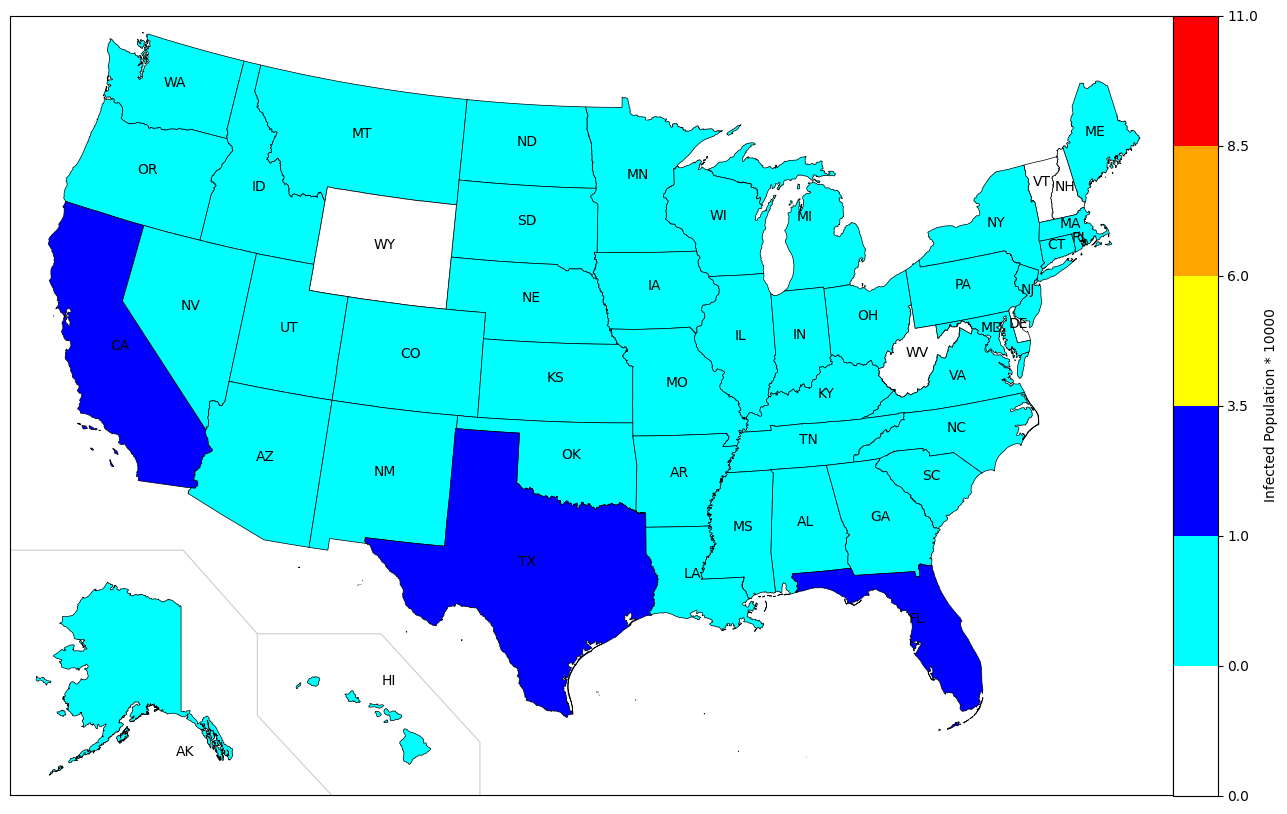

In [ ]:
make_data_visualization_US_Map(m, m_, centroid, values2color(all_information[:,2, 149]))